Loading dataset in chunks...
Dataset loaded.
Unique labels: [0 1]

Training Neural Network...
Epoch 1/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9772 - loss: 0.0672 - val_accuracy: 0.9894 - val_loss: 0.0336
Epoch 2/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - accuracy: 0.9885 - loss: 0.0345 - val_accuracy: 0.9907 - val_loss: 0.0288
Epoch 3/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.9894 - loss: 0.0310 - val_accuracy: 0.9904 - val_loss: 0.0292
Epoch 4/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.9898 - loss: 0.0298 - val_accuracy: 0.9910 - val_loss: 0.0284
Epoch 5/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.9898 - loss: 0.0301 - val_accuracy: 0.9910 - val_loss: 0.0277
Epoch 6/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.9902 - loss: 0.0286 - val_accuracy: 0.9911 - val_loss: 0.0271
Epoch 7/20
9296/9296 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9901 - loss: 0.0279 - val_accuracy: 0.9912 - val_lo

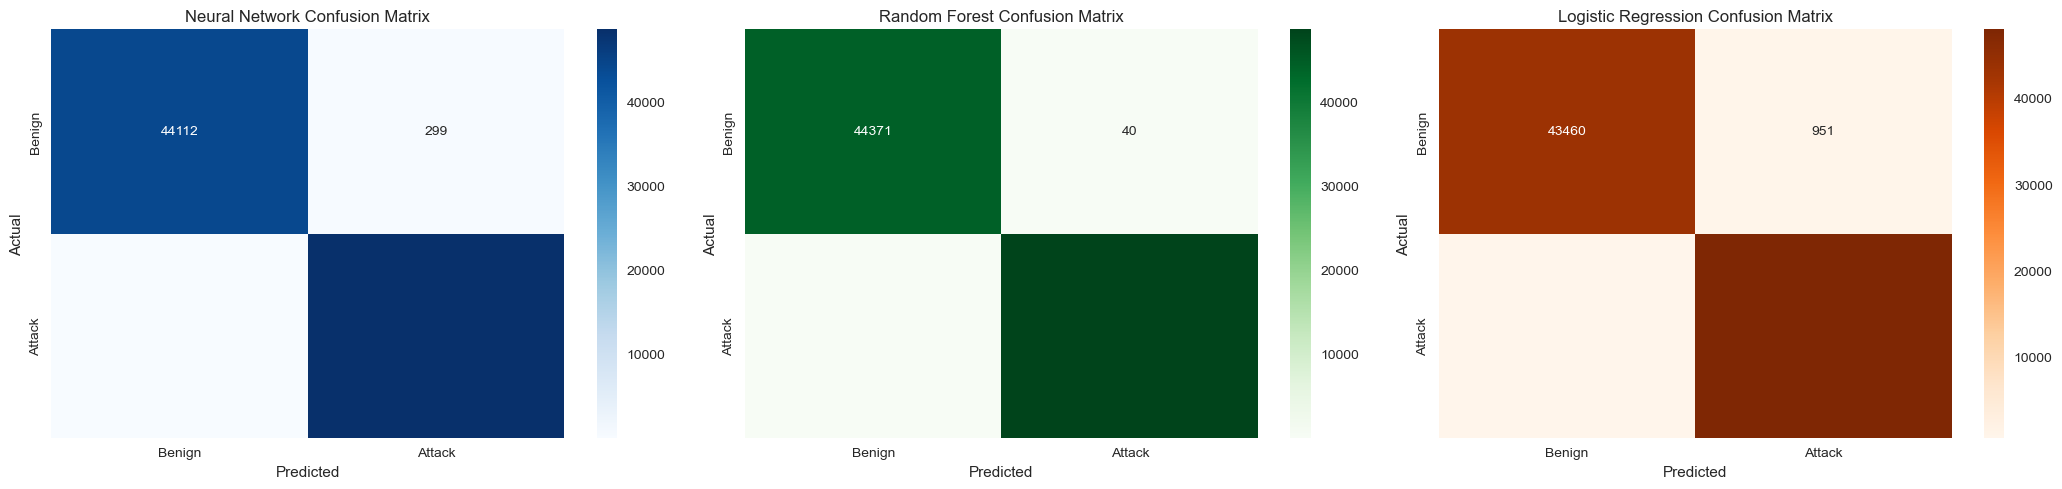

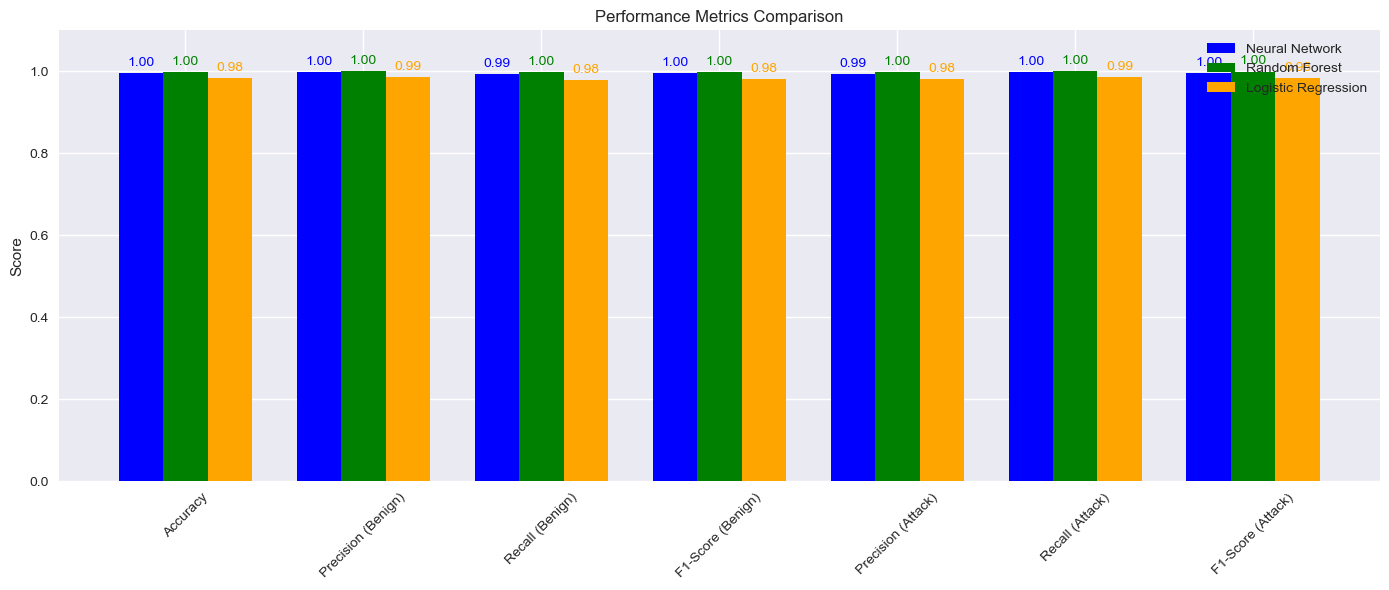

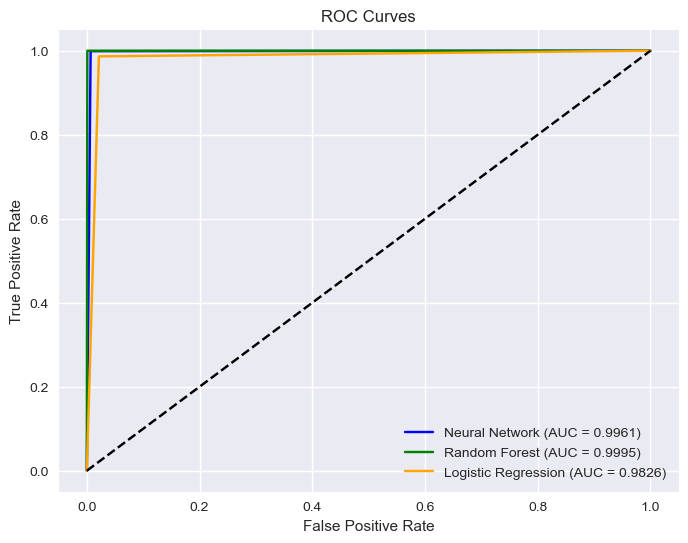

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
import gc

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 10})

file_path = r'C:\Users\USER\Desktop\Capstone\GeneratedLabelledFlows\TrafficLabelling\IMP\RF_LR_NN\Wednesday-workingHours-preprocessed.csv'
print("Loading dataset in chunks...")
chunksize = 100000
chunks = pd.read_csv(file_path, chunksize=chunksize, low_memory=True, dtype_backend='numpy_nullable')
data = pd.concat([chunk for chunk in chunks], ignore_index=True)
print("Dataset loaded.")

# Replace infinite values and drop NaNs
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

# Downcast numeric columns
for col in data.select_dtypes(include=[np.float64, np.int64]).columns:
    if data[col].dtype == np.float64:
        data[col] = data[col].astype(np.float32)
    elif data[col].dtype == np.int64:
        data[col] = data[col].astype(np.int32)

# Find target column
possible_target_columns = ['Label', ' Label', 'label']
target_column = None
for col in possible_target_columns:
    if col in data.columns:
        target_column = col
        break
if target_column is None:
    raise ValueError(f"Target column not found. Available columns: {data.columns.tolist()}")

X = data.drop(target_column, axis=1)
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found in the dataset.")
X = X[numeric_cols].values.astype(np.float32)
y = np.where(data[target_column].values == 'BENIGN', 0, 1).astype(np.int8)
print("Unique labels:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del data, X, y
gc.collect()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

# --- Neural Network ---
print("\nTraining Neural Network...")
nn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(np.int8)
y_pred_nn_proba = nn_model.predict(X_test).astype(np.float32)

cm_nn = confusion_matrix(y_test, y_pred_nn)
report_nn = classification_report(y_test, y_pred_nn, output_dict=True)

print("\nNeural Network Confusion Matrix:")
print(cm_nn)
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

nn_results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)', 
               'True Positives', 'False Negatives', 'True Negatives', 'False Positives'],
    'Value': [report_nn['accuracy'], report_nn['0']['precision'], report_nn['0']['recall'], 
              report_nn['0']['f1-score'], report_nn['1']['precision'], report_nn['1']['recall'], 
              report_nn['1']['f1-score'], cm_nn[1,1], cm_nn[1,0], cm_nn[0,0], cm_nn[0,1]]
})
nn_results_df.to_csv('nn_performance.csv', index=False)

# --- Random Forest ---
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test).astype(np.int8)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1].astype(np.float32)

cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

print("\nRandom Forest Confusion Matrix:")
print(cm_rf)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

rf_results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)', 
               'True Positives', 'False Negatives', 'True Negatives', 'False Positives'],
    'Value': [report_rf['accuracy'], report_rf['0']['precision'], report_rf['0']['recall'], 
              report_rf['0']['f1-score'], report_rf['1']['precision'], report_rf['1']['recall'], 
              report_rf['1']['f1-score'], cm_rf[1,1], cm_rf[1,0], cm_rf[0,0], cm_rf[0,1]]
})
rf_results_df.to_csv('rf_performance.csv', index=False)

# --- Logistic Regression ---
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test).astype(np.int8)
y_pred_lr_proba = lr_model.predict_proba(X_test)[:, 1].astype(np.float32)

cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

print("\nLogistic Regression Confusion Matrix:")
print(cm_lr)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

lr_results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)', 
               'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)', 
               'True Positives', 'False Negatives', 'True Negatives', 'False Positives'],
    'Value': [report_lr['accuracy'], report_lr['0']['precision'], report_lr['0']['recall'], 
              report_lr['0']['f1-score'], report_lr['1']['precision'], report_lr['1']['recall'], 
              report_lr['1']['f1-score'], cm_lr[1,1], cm_lr[1,0], cm_lr[0,0], cm_lr[0,1]]
})
lr_results_df.to_csv('lr_performance.csv', index=False)

# --- Combined Performance Table (Vertical Format) ---
combined_metrics = ['Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)',
                    'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)',
                    'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)', 'True Positives (TP)']

combined_results = pd.DataFrame({
    'Metric': combined_metrics,
    'Neural Network': [report_nn['accuracy'], report_nn['0']['precision'], report_nn['0']['recall'], report_nn['0']['f1-score'],
                       report_nn['1']['precision'], report_nn['1']['recall'], report_nn['1']['f1-score'],
                       cm_nn[0,0], cm_nn[0,1], cm_nn[1,0], cm_nn[1,1]],
    'Random Forest': [report_rf['accuracy'], report_rf['0']['precision'], report_rf['0']['recall'], report_rf['0']['f1-score'],
                      report_rf['1']['precision'], report_rf['1']['recall'], report_rf['1']['f1-score'],
                      cm_rf[0,0], cm_rf[0,1], cm_rf[1,0], cm_rf[1,1]],
    'Logistic Regression': [report_lr['accuracy'], report_lr['0']['precision'], report_lr['0']['recall'], report_lr['0']['f1-score'],
                            report_lr['1']['precision'], report_lr['1']['recall'], report_lr['1']['f1-score'],
                            cm_lr[0,0], cm_lr[0,1], cm_lr[1,0], cm_lr[1,1]]
})
combined_results.to_csv('model_comparison_vertical.csv', index=False)

print("\nCombined Performance Comparison Table (Vertical):")
print(tabulate(combined_results, headers='keys', tablefmt='grid'))

# --- Visualizations ---
# Confusion Matrix Heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'], ax=ax1)
ax1.set_title('Neural Network Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'], ax=ax2)
ax2.set_title('Random Forest Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'], ax=ax3)
ax3.set_title('Logistic Regression Confusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()

# Performance Metrics Bar Plot
metrics = ['Accuracy', 'Precision (Benign)', 'Recall (Benign)', 'F1-Score (Benign)',
           'Precision (Attack)', 'Recall (Attack)', 'F1-Score (Attack)']
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.25
x = np.arange(len(metrics))
ax.bar(x - bar_width, [combined_results['Neural Network'][i] for i in range(len(metrics))], bar_width, label='Neural Network', color='blue')
ax.bar(x, [combined_results['Random Forest'][i] for i in range(len(metrics))], bar_width, label='Random Forest', color='green')
ax.bar(x + bar_width, [combined_results['Logistic Regression'][i] for i in range(len(metrics))], bar_width, label='Logistic Regression', color='orange')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.set_title('Performance Metrics Comparison')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.1)
for i in range(len(metrics)):
    ax.text(i - bar_width, combined_results['Neural Network'][i] + 0.01, f"{combined_results['Neural Network'][i]:.2f}", ha='center', va='bottom', color='blue')
    ax.text(i, combined_results['Random Forest'][i] + 0.01, f"{combined_results['Random Forest'][i]:.2f}", ha='center', va='bottom', color='green')
    ax.text(i + bar_width, combined_results['Logistic Regression'][i] + 0.01, f"{combined_results['Logistic Regression'][i]:.2f}", ha='center', va='bottom', color='orange')
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.savefig('performance_metrics.png', dpi=300)
plt.show()

# ROC Curves
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='blue', label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_lr, tpr_lr, color='orange', label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves.png', dpi=300)
plt.show()
